In [407]:
import numpy
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
from keras import layers
from keras.layers import Input, Dense, Lambda, Layer,Flatten,Reshape, BatchNormalization 
from keras.models import Model
from keras import backend, metrics
from keras.datasets import mnist
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from keras.optimizers import SGD,Adam

In [629]:

# 2次元正規分布から1点サンプリングする補助関数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + backend.exp(z_log_var * 0.5) * epsilon

class CustomVariationalLayer(Layer):
    """Keras の Layer クラスを継承してオリジナルの損失関数を付加するレイヤー"""
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean): 
        """オリジナルの損失関数"""
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        # 入力と出力の交差エントロピー
        #xent_loss = 784 * metrics.binary_crossentropy(x, x_decoded_mean) 
        xent_loss = 784 * metrics.mse(x, x_decoded_mean) 

        # 事前分布と事後分布のKL情報量
        kl_loss = - 0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
        return backend.mean(xent_loss +  kl_loss)


    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs) # オリジナルの損失関数を付加
        return x # この自作レイヤーの出力を一応定義しておきますが、今回この出力は全く使いません

batch_size = 100
latent_dim = 2
epsilon_std = 1.0

# 変分自己符号化器を構築する

# エンコーダ
x = Input(batch_shape=(batch_size, 28,28))
h = Reshape((28,28,1))(x)

h1 = layers.SeparableConv2D(64,3,padding="same")(h)
h1 = layers.SeparableConv2D(64,3,padding="same")(h1)
h1 = layers.MaxPool2D(pool_size=2,padding="same")(h1)
h1 = BatchNormalization()(h1)
h1 = layers.LeakyReLU()(h1)

h2 = layers.SeparableConv2D(64,3,padding="same")(h1)
h2 = layers.SeparableConv2D(64,3,padding="same")(h2)
h2 = layers.MaxPool2D(pool_size=2,padding="same")(h2)
h2 = BatchNormalization()(h2)
h2 = layers.LeakyReLU()(h2)

shape_before_flattening = K.int_shape(h2)

h = Flatten()(h2)
h = layers.Dropout(0.1)(h)

z_mean = Dense(latent_dim)(h)
z_mean = layers.Dropout(0.1)(z_mean)

z_log_var = Dense(latent_dim)(h)
z_log_var = layers.Dropout(0.1)(z_log_var)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# デコーダ
h = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(z)
#h = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(z)
h = Reshape(shape_before_flattening[1:])(h)


h = layers.Conv2DTranspose(64,3,padding="same")(h)
h = layers.Conv2DTranspose(64,3,padding="same")(h)
h = layers.UpSampling2D(2)(h)
h = BatchNormalization()(h)
h = layers.LeakyReLU()(h)

h = layers.Conv2DTranspose(64,3,padding="same")(h)
h = layers.Conv2DTranspose(64,3,padding="same")(h)
h = layers.UpSampling2D(2)(h)
h = BatchNormalization()(h)
h = layers.LeakyReLU()(h)

#decoder_h = Dense(intermediate_dim, activation='relu')
#decoder_mean = Dense(original_dim, activation='sigmoid')
#h_decoded = decoder_h(z)
#x_decoded_mean = decoder_mean(h_decoded)

#h_decoded = Dense(intermediate_dim, activation='relu')(z)

x_decoded_mean = Dense(1, activation='sigmoid')(h)

#x_decoded_mean = layers.Conv2D(1,3,padding ="same", activation='sigmoid')(h)
#x_decoded_mean = Reshape([28,28])(x_decoded_mean)
# カスタマイズした損失関数を付加する訓練用レイヤー
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
#vae.compile(optimizer='adam', loss=None)


In [630]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_184 (InputLayer)          (100, 28, 28)        0                                            
__________________________________________________________________________________________________
reshape_313 (Reshape)           (100, 28, 28, 1)     0           input_184[0][0]                  
__________________________________________________________________________________________________
separable_conv2d_68 (SeparableC (100, 28, 28, 64)    137         reshape_313[0][0]                
__________________________________________________________________________________________________
separable_conv2d_69 (SeparableC (100, 28, 28, 64)    4736        separable_conv2d_68[0][0]        
__________________________________________________________________________________________________
max_poolin

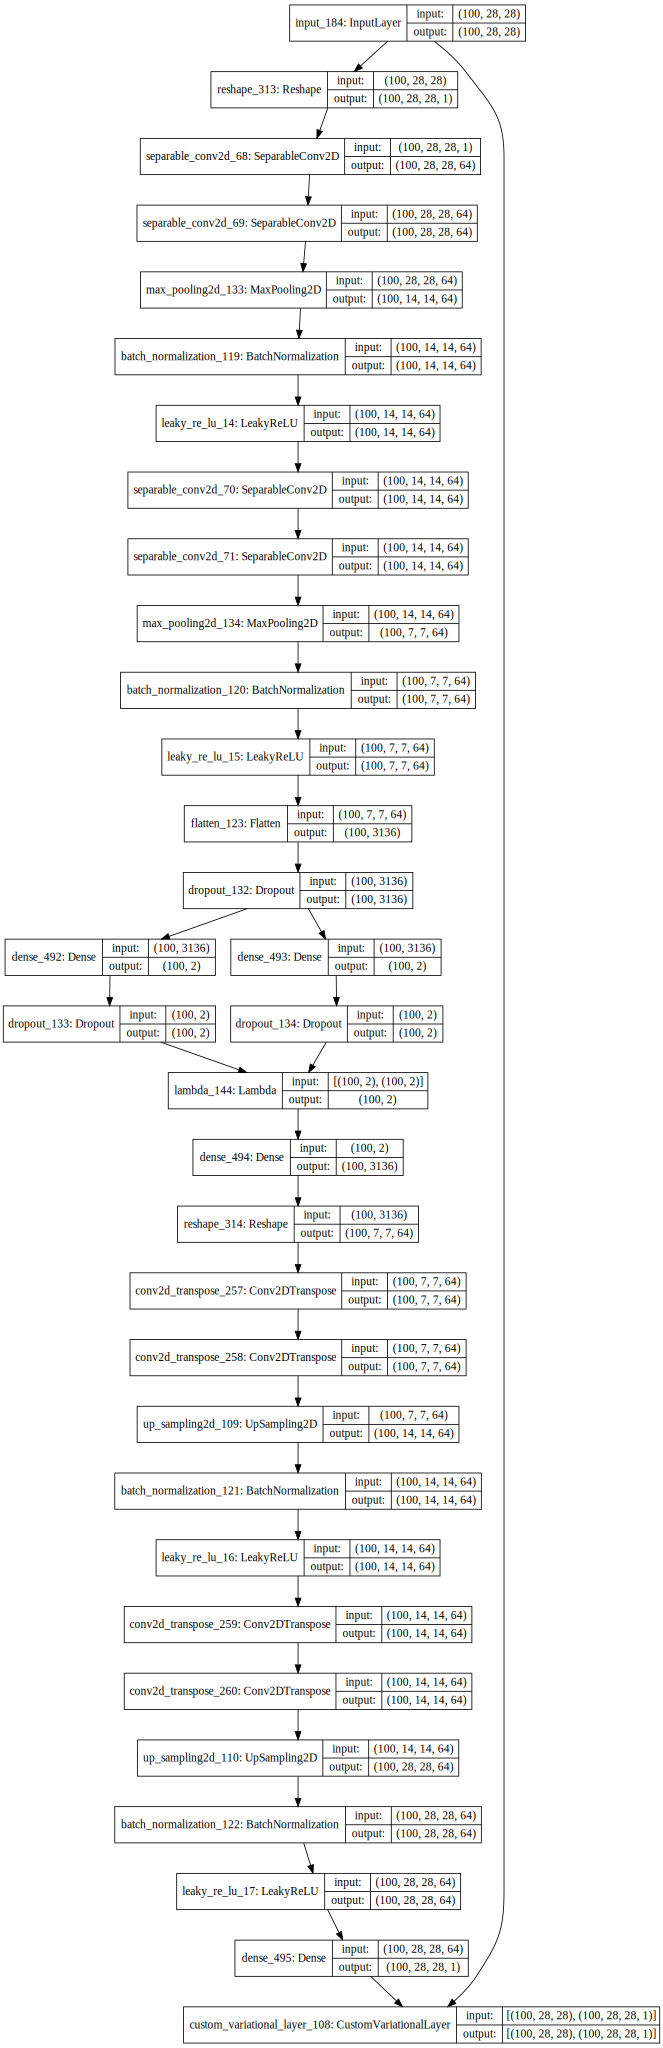

In [631]:
SVG(model_to_dot(vae,show_shapes=True).create(prog='dot', format='svg'))

In [632]:
# ============================================================
# モデルを訓練します
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), numpy.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), numpy.prod(x_test.shape[1:])))

In [633]:
epochs = 1000
vae.compile(optimizer='adam', loss=None)
vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/1000
60000/60000 [==============================] - 392s 7ms/step - loss: 53.8363
Epoch 2/1000
60000/60000 [==============================] - 349s 6ms/step - loss: 47.0980
Epoch 3/1000
60000/60000 [==============================] - 360s 6ms/step - loss: 46.7160
Epoch 4/1000
60000/60000 [==============================] - 351s 6ms/step - loss: 46.4622
Epoch 5/1000
60000/60000 [==============================] - 335s 6ms/step - loss: 46.3178
Epoch 6/1000
60000/60000 [==============================] - 343s 6ms/step - loss: 46.1171
Epoch 7/1000
60000/60000 [==============================] - 354s 6ms/step - loss: 46.0756
Epoch 8/1000
60000/60000 [==============================] - 355s 6ms/step - loss: 46.0190
Epoch 9/1000
60000/60000 [==============================] - 355s 6ms/step - loss: 45.8735
Epoch 10/1000
60000/60000 [==============================] - 355s 6ms/step - loss: 45.8758
Epoch 11/1000
60000/60000 [==============================] - 354s 6ms/step - loss: 45.7910
Epoch 12

KeyboardInterrupt: 

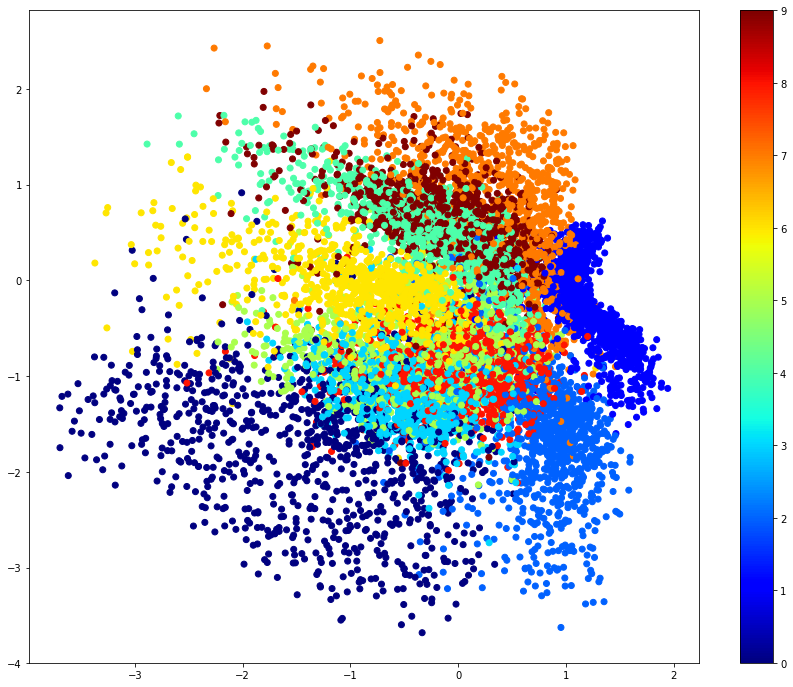

In [634]:

#============================================================
  # 結果を表示します

# (1) 隠れ変数空間のプロット（エンコードした状態のプロット）
encoder = Model(x, z_mean) # エンコーダのみ分離
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15, 12))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap="jet")
plt.colorbar()
plt.show()


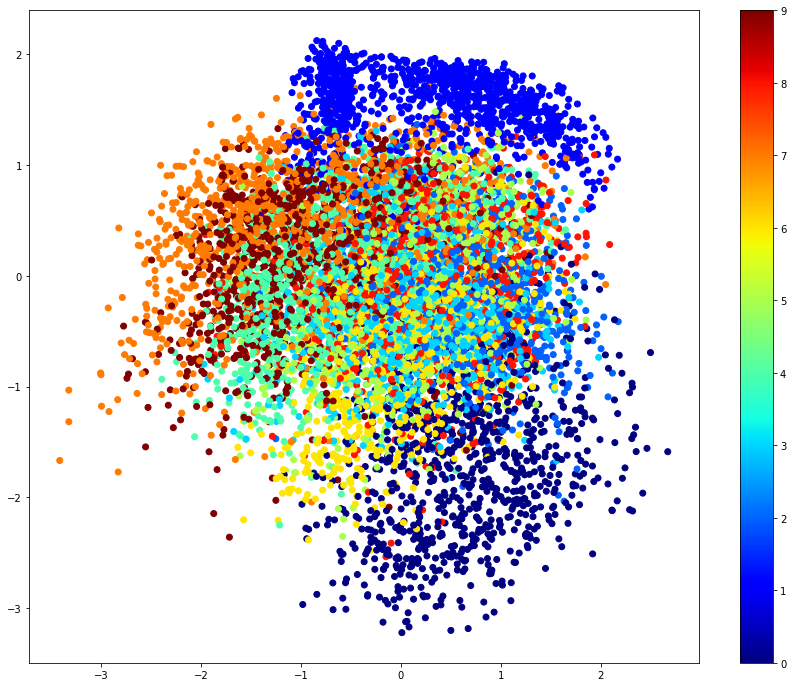

In [595]:

#============================================================
  # 結果を表示します

# (1) 隠れ変数空間のプロット（エンコードした状態のプロット）
encoder = Model(x, z_mean) # エンコーダのみ分離
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15, 12))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap="jet")
plt.colorbar()
plt.show()


In [496]:
x_train[0].shape

(28, 28)

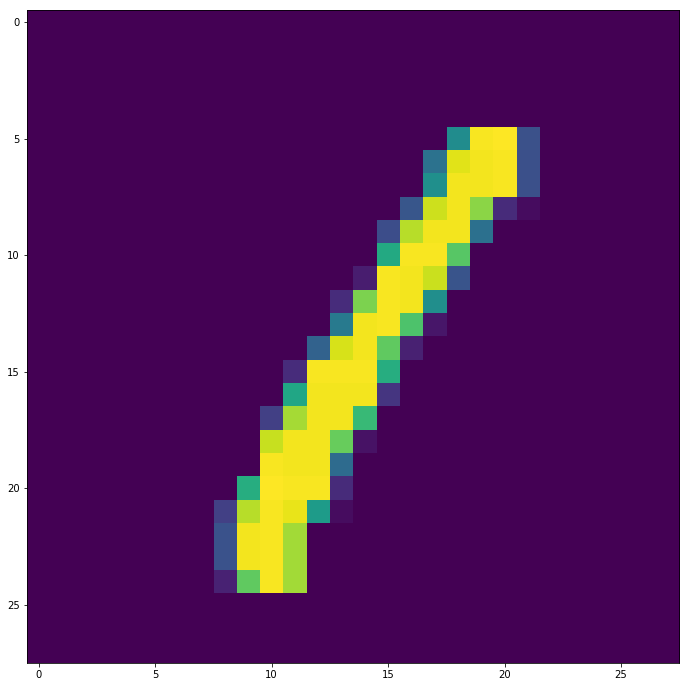

In [504]:
plt.imshow(vae.predict(x_train[3][np.newaxis,:,:]).reshape([28,28]))
plt.show()

In [490]:
# (2) 隠れ変数空間からサンプリングした点がどんな手書き数字を生成するか（どうデコードされるか）をプロット
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean) # デコーダのみ分離

n = 15  # 15x15 個の手書き数字をプロットする
digit_size = 28
figure = numpy.zeros((digit_size * n, digit_size * n))

grid_x = numpy.linspace(-15, 15, n)
grid_y = numpy.linspace(-15, 15, n)


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = numpy.array([[xi,a yi]])
        x_decoded = generator.predict(z_sample)
        #digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

TypeError: 'Tensor' object is not callable